# **AudioFuse**

This script can be used to evaluate AudioFuse models using pretrained weights from saved models.

## **Evaluation Script**


Loading model for final evaluation from: /content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PASCAL Heart Sounds/best_model_pascal_head_trained_High AUC.keras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spec_patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 118 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 114 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Extracting true labels...

Skipping training history plot (no history object available).

Calculating key performance metrics...
Matthews Correlation Coefficient: 0.4519
Cohen's Kappa Score: 0.4518
AUC-ROC Score: 0.7181

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7778    0.7925    0.7850        53
    Abnormal     0.6765    0.6571    0.6667        35

    accuracy                         0.7386        88
   macro avg     0.7271    0.7248    0.7259        88
weighted avg     0.7375    0.7386    0.7380        88


Plotting Confusion Matrix...


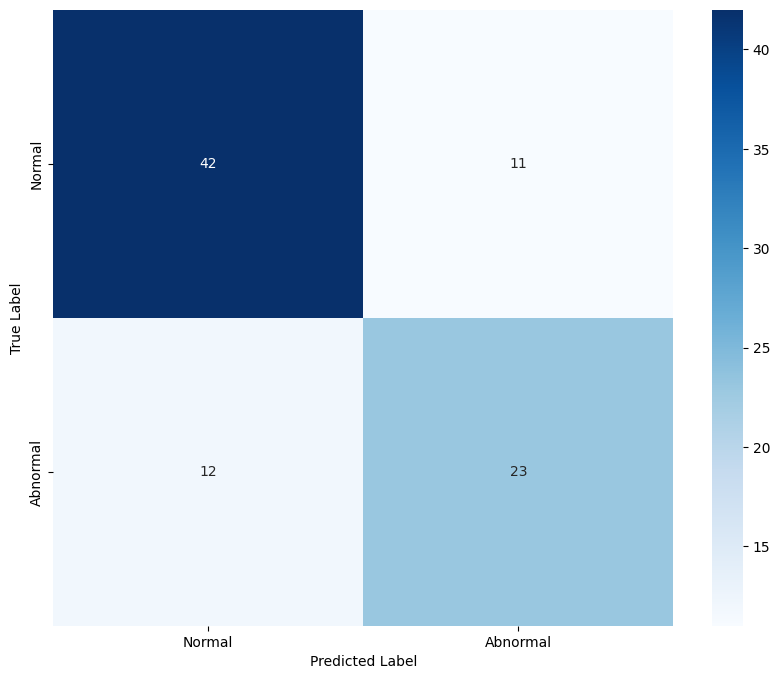


Plotting ROC Curves...


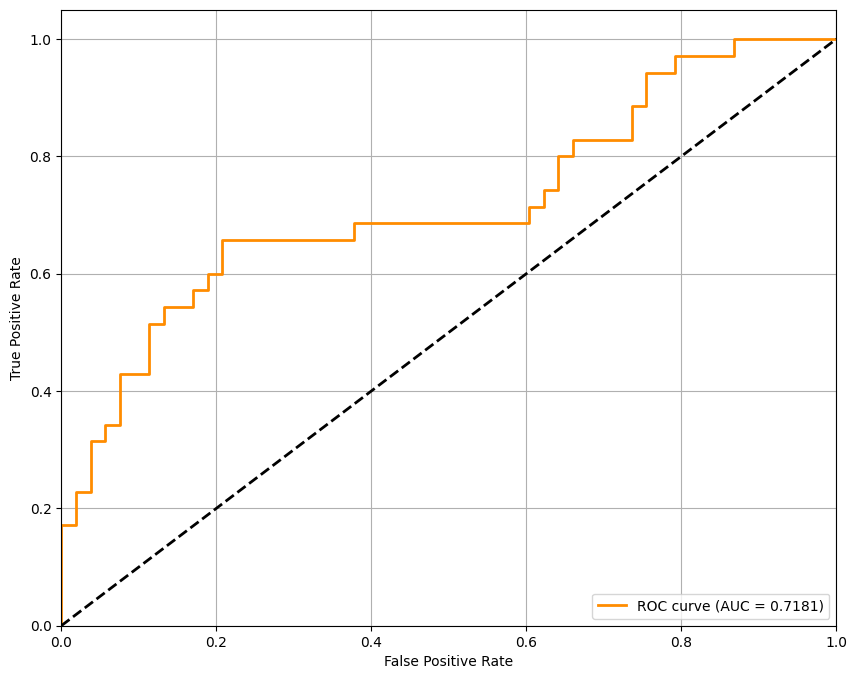

In [ ]:
# ================================================================
# Block: Comprehensive Evaluation
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, cohen_kappa_score, roc_auc_score, roc_curve

# --- We need to register the custom layer to load the model ---
@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

# --- Defining the path to the model we want to evaluate ---
DRIVE_FOLDER = "/content/drive/MyDrive/Multimodal Audio Fusion"
MODEL_TO_EVALUATE_PATH = os.path.join(DRIVE_FOLDER, "Experiments/PASCAL Heart Sounds/best_model_pascal_head_trained_High AUC.keras")

# --- Loading the specified model ---
print(f"\nLoading model for final evaluation from: {MODEL_TO_EVALUATE_PATH}")
best_model = keras.models.load_model(MODEL_TO_EVALUATE_PATH)

# --- Creating a finite validation dataset for evaluation ---
print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_hybrid_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Getting predictions on the validation set ---
print("Generating predictions on the validation set...")
predictions = best_model.predict(val_ds_eval)

# --- Getting true labels directly from the DataFrame ---
print("Extracting true labels...")
y_true = val_df['label'].values

# The number of true labels might be slightly larger than predictions if the
# dataset size is not a multiple of the batch size. Trimming to match.
num_predictions = len(predictions)
y_true = y_true[:num_predictions]


# --- Processing predictions based on the task ---
NUM_CLASSES = 2
if NUM_CLASSES == 2:
    y_prob = tf.nn.sigmoid(predictions).numpy().flatten()
    y_pred = (y_prob > 0.549).astype(int)
else:
    y_prob = predictions
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
CLASS_NAMES = ['Normal', 'Abnormal']
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
#plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))
if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc_i = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {CLASS_NAMES[i]} (AUC = {roc_auc_i:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()